# Attention Unet

## Install dependencies and import

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
!pip install tqdm -U
!pip install nibabel
!pip install h5py
!pip install dominate
!pip install pydicom
!pip install https://github.com/ozan-oktay/torchsample/tarball/master#egg=torchsample-0.1.3

     |████████████████████████████████| 61kB 10.3MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


     |████████████████████████████████| 35.1MB 88kB/s 
     \ 389kB 12.7MB/s
  Created wheel for torchsample: filename=torchsample-0.1.3-cp36-none-any.whl size=45258 sha256=9654645abafe5482202a2f82da4cca643abb5a3c5946f9a19a0073545fc31512
  Stored in directory: /tmp/pip-ephem-wheel-cache-tf1gp_yv/wheels/c2/f9/43/f2601da3bddeee29bc2728016b074379a267135b2b64c04aa7
  ERROR: Failed building wheel for torchsample
  Running setup.py clean for torchsample
  ERROR: Failed cleaning build dir for torchsample
Successfully built torchsample
Failed to build torchsample


In [0]:
import os
import shutil
import zipfile
import json
import collections
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pydicom
import numpy as np
import pandas as pd
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numbers
import PIL

## Setup dataset

In [0]:
# local machine directories
DATA_DIR = "/content/data/"
DATA_MASKS_DIR = DATA_DIR + "masks"
DATA_DICOM_DIR = DATA_DIR + "input"

# google drive directories
DATA_ZIP_FILE_PATH = "/content/gdrive/My Drive/mlmi/dataset/input.zip"
MASKS_DIR = "/content/gdrive/My Drive/mlmi/dataset/masks/"
TENSORBOARD_LOGS_DIR = "/content/gdrive/My Drive/mlmi/results/tensorboard/"
MODEL_SAVE_DIR = "/content/gdrive/My Drive/mlmi/results/model/"
IMG_RESULT_SAVE_DIR = r'/content/gdrive/My Drive/mlmi/results/imgs/'


Copy masks from gdrive

In [0]:
# create data directory locally
if os.path.exists(DATA_DIR) == False:
  os.makedirs(DATA_DIR)
  print("Create directory: " + DATA_DIR)

Create directory: /content/data/


In [0]:
if os.path.exists(DATA_MASKS_DIR):
  shutil.rmtree(DATA_MASKS_DIR)
  print("Deleted old masks directory: " + DATA_MASKS_DIR)

!cp -r "$MASKS_DIR" $DATA_DIR
%ls $DATA_MASKS_DIR

simm_DS_test.csv  simm_DS_train.csv  simm_DS_validation.csv  train-rle.csv


In [0]:
#### uncomment this code to reduce the train set size
# includeImagesCounts = 50
# trainSetCsv = pd.read_csv(DATA_MASKS_DIR + '/simm_DS_train.csv')
# tsReduced = trainSetCsv[:includeImagesCounts]
# tsReduced[:5]

# tsReduced.to_csv(DATA_MASKS_DIR + '/simm_DS_train.csv', index = None, header=True)

Extract DICOM files from zip

In [0]:
# only extract if input folder doesn't exists
if os.path.exists(DATA_DICOM_DIR) == False:
  #!unzip "$DATA_ZIP_FILE_PATH" -d "$DATA_DIR"
  zip_ref = zipfile.ZipFile(DATA_ZIP_FILE_PATH, 'r')
  zip_ref.extractall(DATA_DIR)
  zip_ref.close()
  print("Extracted dicom zip file to directory: " + DATA_DICOM_DIR)

%ls $DATA_DICOM_DIR
#%ls "$DATA_DICOM_DIR/siim/dicom-images-train"

Extracted dicom zip file to directory: /content/data/input
siim/


## Model Definitions

In [0]:
def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        nn.init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        nn.init.normal(m.weight.data, 1.0, 0.02)
        nn.init.constant(m.bias.data, 0.0)
        
class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n+1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True),)
                setattr(self, 'conv%d'%i, conv)
                in_size = out_size

        else:
            for i in range(1, n+1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True),)
                setattr(self, 'conv%d'%i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n+1):
            conv = getattr(self, 'conv%d'%i)
            x = conv(x)

        return x

class unetUp2(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, is_batchnorm=True):
        super(unetUp2, self).__init__()
        self.conv = unetConv2(in_size + out_size, out_size, is_batchnorm)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('unetConv2') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, inputs1, inputs2):
        outputs2 = self.up(inputs2)
        # offset = outputs2.size()[1] - inputs1.size()[1]
        # padding = [0, 0, 0, 0, offset // 2, offset // 2]
        # outputs1 = F.pad(inputs1, padding)
        outputs1 = inputs1
        cat = torch.cat([outputs1, outputs2], 1)
        return self.conv(cat)

class UnetGridGatingSignal2(nn.Module):
    def __init__(self, in_size, out_size, ks=1, is_batchnorm=True):
        super(UnetGridGatingSignal2, self).__init__()

        if is_batchnorm:
            self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, ks),
                                       nn.BatchNorm2d(out_size),
                                       nn.ReLU(inplace=True),
                                       )
        else:
            self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, ks),
                                       nn.ReLU(inplace=True),
                                       )

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        return outputs

class UnetDsv2(nn.Module):
    def __init__(self, in_size, out_size, scale_factor):
        super(UnetDsv2, self).__init__()
        self.dsv = nn.Sequential(nn.Conv2d(in_size, out_size, kernel_size=1, stride=1, padding=0),
                                 nn.Upsample(scale_factor=scale_factor, mode='bilinear'), )

    def forward(self, input):
        return self.dsv(input)

class _GridAttentionBlockND(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels=None, dimension=3, mode='concatenation',
                 sub_sample_factor=(2,2,2)):
        super(_GridAttentionBlockND, self).__init__()

        assert dimension in [2, 3]
        assert mode in ['concatenation', 'concatenation_debug', 'concatenation_residual']

        # Downsampling rate for the input featuremap
        if isinstance(sub_sample_factor, tuple): self.sub_sample_factor = sub_sample_factor
        elif isinstance(sub_sample_factor, list): self.sub_sample_factor = tuple(sub_sample_factor)
        else: self.sub_sample_factor = tuple([sub_sample_factor]) * dimension

        # Default parameter set
        self.mode = mode
        self.dimension = dimension
        self.sub_sample_kernel_size = self.sub_sample_factor

        # Number of channels (pixel dimensions)
        self.in_channels = in_channels
        self.gating_channels = gating_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        if dimension == 3:
            conv_nd = nn.Conv3d
            bn = nn.BatchNorm3d
            self.upsample_mode = 'trilinear'
        elif dimension == 2:
            conv_nd = nn.Conv2d
            bn = nn.BatchNorm2d
            self.upsample_mode = 'bilinear'
        else:
            raise NotImplemented

        # Output transform
        self.W = nn.Sequential(
            conv_nd(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=1, stride=1, padding=0),
            bn(self.in_channels),
        )

        # Theta^T * x_ij + Phi^T * gating_signal + bias
        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=self.sub_sample_kernel_size, stride=self.sub_sample_factor, padding=0, bias=False)
        self.phi = conv_nd(in_channels=self.gating_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0, bias=True)
        self.psi = conv_nd(in_channels=self.inter_channels, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

        # Initialise weights
        for m in self.children():
            init_weights(m, init_type='kaiming')

        # Define the operation
        if mode == 'concatenation':
            self.operation_function = self._concatenation
        elif mode == 'concatenation_debug':
            self.operation_function = self._concatenation_debug
        elif mode == 'concatenation_residual':
            self.operation_function = self._concatenation_residual
        else:
            raise NotImplementedError('Unknown operation function.')


    def forward(self, x, g):
        '''
        :param x: (b, c, t, h, w)
        :param g: (b, g_d)
        :return:
        '''

        output = self.operation_function(x, g)
        return output

    def _concatenation(self, x, g):
        input_size = x.size()
        batch_size = input_size[0]
        assert batch_size == g.size(0)

        # theta => (b, c, t, h, w) -> (b, i_c, t, h, w) -> (b, i_c, thw)
        # phi   => (b, g_d) -> (b, i_c)
        theta_x = self.theta(x)
        theta_x_size = theta_x.size()

        # g (b, c, t', h', w') -> phi_g (b, i_c, t', h', w')
        #  Relu(theta_x + phi_g + bias) -> f = (b, i_c, thw) -> (b, i_c, t/s1, h/s2, w/s3)
        phi_g = F.interpolate(self.phi(g), size=theta_x_size[2:], mode=self.upsample_mode)
        f = F.relu(theta_x + phi_g, inplace=True)

        #  psi^T * f -> (b, psi_i_c, t/s1, h/s2, w/s3)
        sigm_psi_f = torch.sigmoid(self.psi(f))

        # upsample the attentions and multiply
        sigm_psi_f = F.interpolate(sigm_psi_f, size=input_size[2:], mode=self.upsample_mode)
        y = sigm_psi_f.expand_as(x) * x
        W_y = self.W(y)

        return W_y, sigm_psi_f

class GridAttentionBlock2D(_GridAttentionBlockND):
    def __init__(self, in_channels, gating_channels, inter_channels=None, mode='concatenation',
                 sub_sample_factor=(2,2,2)):
        super(GridAttentionBlock2D, self).__init__(in_channels,
                                                   inter_channels=inter_channels,
                                                   gating_channels=gating_channels,
                                                   dimension=2, mode=mode,
                                                   sub_sample_factor=sub_sample_factor
                                                   )


class MultiAttentionBlock(nn.Module):
    def __init__(self, in_size, gate_size, inter_size, nonlocal_mode, sub_sample_factor):
        super(MultiAttentionBlock, self).__init__()
        self.gate_block_1 = GridAttentionBlock2D(in_channels=in_size, gating_channels=gate_size,
                                                 inter_channels=inter_size, mode=nonlocal_mode,
                                                 sub_sample_factor= sub_sample_factor)
        self.combine_gates = nn.Sequential(nn.Conv2d(in_size, in_size, kernel_size=1, stride=1, padding=0),
                                           nn.BatchNorm2d(in_size),
                                           nn.ReLU(inplace=True)
                                           )

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('GridAttentionBlock2D') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, input, gating_signal):
        gate_1, attention_1 = self.gate_block_1(input, gating_signal)
        return self.combine_gates(gate_1), attention_1

In [0]:
class unet_simm(nn.Module):

    def __init__(self, feature_scale, n_classes, is_deconv, in_channels,
                 nonlocal_mode, attention_dsample, is_batchnorm, dropout):
        super(unet_simm, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale

        filters = [64, 128, 256, 512, 1024]
        filters = [int(x / self.feature_scale) for x in filters]
        # filter [16, 32, 64, 128, 256]

        # downsampling
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm, ks=3)
        self.dropout1 = None
        if dropout > 0.0:
          self.dropout1 = nn.Dropout2d(p=dropout)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm, ks=3)
        self.dropout2 = None
        if dropout > 0.0:
          self.dropout2 = nn.Dropout2d(p=dropout)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm, ks=3)
        self.dropout3 = None
        if dropout > 0.0:
          self.dropout3 = nn.Dropout2d(p=dropout)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm, ks=3)
        self.dropout4 = None
        if dropout > 0.0:
          self.dropout4 = nn.Dropout2d(p=dropout)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.center = unetConv2(filters[3], filters[4], self.is_batchnorm, ks=3)
        self.gating = UnetGridGatingSignal2(filters[4], filters[4], ks=1, is_batchnorm=self.is_batchnorm)

        # attention blocks
        self.attentionblock2 = MultiAttentionBlock(in_size=filters[1], gate_size=filters[2], inter_size=filters[1],
                                                   nonlocal_mode=nonlocal_mode, sub_sample_factor= attention_dsample)
        self.attentionblock3 = MultiAttentionBlock(in_size=filters[2], gate_size=filters[3], inter_size=filters[2],
                                                   nonlocal_mode=nonlocal_mode, sub_sample_factor= attention_dsample)
        self.attentionblock4 = MultiAttentionBlock(in_size=filters[3], gate_size=filters[4], inter_size=filters[3],
                                                   nonlocal_mode=nonlocal_mode, sub_sample_factor= attention_dsample)

        # upsampling
        self.up_concat4 = unetUp2(filters[4], filters[3], False, is_batchnorm)
        self.up_concat3 = unetUp2(filters[3], filters[2], False, is_batchnorm)
        self.up_concat2 = unetUp2(filters[2], filters[1], False, is_batchnorm)
        self.up_concat1 = unetUp2(filters[1], filters[0], False, is_batchnorm)

        # deep supervision
        self.dsv4 = UnetDsv2(in_size=filters[3], out_size=n_classes, scale_factor=8)
        self.dsv3 = UnetDsv2(in_size=filters[2], out_size=n_classes, scale_factor=4)
        self.dsv2 = UnetDsv2(in_size=filters[1], out_size=n_classes, scale_factor=2)
        self.dsv1 = nn.Conv2d(in_channels=filters[0], out_channels=n_classes, kernel_size=1)

        # final conv (without any concat)
        self.final = nn.Conv2d(n_classes*4, n_classes, 1)

        self.last_attention_coefficients = []

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        # Feature Extraction
        conv1 = self.conv1(inputs)
        if self.dropout1:
          conv1 = self.dropout1(conv1)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.conv2(maxpool1)
        if self.dropout2:
          conv2 = self.dropout2(conv2)
        maxpool2 = self.maxpool2(conv2)

        conv3 = self.conv3(maxpool2)
        if self.dropout3:
          conv3 = self.dropout3(conv3)
        maxpool3 = self.maxpool3(conv3)

        conv4 = self.conv4(maxpool3)
        if self.dropout4:
          conv4 = self.dropout4(conv4)
        maxpool4 = self.maxpool4(conv4)

        # Gating Signal Generation
        center = self.center(maxpool4)
        gating = self.gating(center)

        # Attention Mechanism
        attention_coefficients = []
        # Upscaling Part (Decoder)
        g_conv4, att4 = self.attentionblock4(conv4, gating)
        up4 = self.up_concat4(g_conv4, center)
        g_conv3, att3 = self.attentionblock3(conv3, up4)
        up3 = self.up_concat3(g_conv3, up4)
        g_conv2, att2 = self.attentionblock2(conv2, up3)
        up2 = self.up_concat2(g_conv2, up3)
        up1 = self.up_concat1(conv1, up2)

        attention_coefficients.append(att4)
        attention_coefficients.append(att3)
        attention_coefficients.append(att2)

        self.last_attention_coefficients = attention_coefficients

        # Deep Supervision
        dsv4 = self.dsv4(up4)
        dsv3 = self.dsv3(up3)
        dsv2 = self.dsv2(up2)
        dsv1 = self.dsv1(up1)
        final = self.final(torch.cat([dsv1,dsv2,dsv3,dsv4], dim=1))

        final = torch.sigmoid(final)
        return final

    def getLastAttentionCoefficients(self):
        return self.last_attention_coefficients

In [0]:
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)
    
class SIMMDataset(Dataset):
    """SIMM dataset."""

    def __init__(self, root_dir, split, transform=None):
        """
        Args:
            dicomPaths (Array<string>): Array of DICOM file Paths.
            mask_csv_file (string): csv file with encoded masks (rle).
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.root_dir = root_dir
        self.dir_postfix = 'input/siim/'

        self.im_height = 1024
        self.im_width = 1024
        self.im_chan = 1

        ## Read masks file
        mask_csv_file = root_dir + 'masks/train-rle.csv' 
        # print("Reading masks from: " + mask_csv_file)
        self.encodedMasks = pd.read_csv(mask_csv_file, names=['ImageId', 'EncodedPixels'], index_col='ImageId')

        ## Read dataset file names
        dsFile = root_dir + 'masks/simm_DS_' + split + '.csv'
        # print("Reading ds from: " + dsFile)
        dsFileData = pd.read_csv(dsFile)
        self.dicomPaths = dsFileData['path'].tolist()
        # print("READ")
        self.transform = transform

    def __len__(self):
        return len(self.dicomPaths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read dicom file
        dPath = self.dicomPaths[idx]
        dicom = pydicom.dcmread(self.root_dir + self.dir_postfix + dPath)
        
        # get image from dicom to numpy array
        image = np.array(dicom.pixel_array)
        
        # get mask (in rle) from csv
        landmarks = np.zeros((self.im_height, self.im_width), dtype=np.bool)
        
        fileId = dPath.split('/')[-1][:-4]
        rle = self.encodedMasks.loc[fileId, 'EncodedPixels']
        try:
            if type(rle) == str: # if single rle
                decodedRle = rle2mask(rle, self.im_height, self.im_width)
#                 landmarks = np.expand_dims(decodedRle, axis=2)
                landmarks = decodedRle
            else: # if multiple rle
                for x in rle:
                    decodedRle = rle2mask(x, self.im_height, self.im_width)
                    landmarks = landmarks + decodedRle
#                     landmarks = landmarks + np.expand_dims(decodedRle, axis=2)
        except Exception as e:
            print(e)
            
        ## BECAUSE WHEN PLOTING THE GRAPHS WE HAVE TO TRANSPOSE IT.
        landmarks = landmarks.T

        # for some images, we have multiple masks, so we are adding the masks
        # which results in some pixels to > 1
        landmarks = (landmarks >= 1).astype('float64')

        if self.transform:
          # converting numpy array to PIL image
          # because torchvision transforms needs PIL image
          image = PIL.Image.fromarray(image)
          landmarks = PIL.Image.fromarray(landmarks)

          # apply transformation
          image, landmarks = self.transform(image, landmarks)

          # converting back to numpy array from PIL image
          image = np.array(image)
          landmarks = np.array(landmarks)

        img = np.expand_dims(image, axis=0)
        mk = np.expand_dims(landmarks, axis=0)
        img = img / 255

        return img, mk

In [0]:
class SIMMSoftDiceLoss(nn.Module):
    def __init__(self):
        super(SIMMSoftDiceLoss, self).__init__()

    def forward(self, input, target):
        smooth = 0.01
        batch_size = input.size(0)

        input = input.view(batch_size, -1)
        labels = target.contiguous().view(batch_size, -1)

        inter = torch.sum(input * labels, 1) + smooth
        union = torch.sum(input, 1) + torch.sum(labels, 1) + smooth

        score = torch.sum(2.0 * inter / union, 0)
        score = 1.0 - score / float(batch_size)
        
        return score

class SIMMHardDiceScore(nn.Module):
    def __init__(self):
        super(SIMMHardDiceScore, self).__init__()

    def forward(self, input, target):
        smooth = 0.01

        # convert input to hard classification
        hardClf = input.clone()
        hardClf[hardClf > 0.5] = 1
        hardClf[hardClf <= 0.5] = 0

        labels = target.clone()
        batch_size = hardClf.size(0)

        hardClf = hardClf.view(batch_size, -1)
        labels = labels.contiguous().view(batch_size, -1)

        inter = torch.sum(hardClf * labels, 1) + smooth
        union = torch.sum(hardClf, 1) + torch.sum(labels, 1) + smooth

        score = torch.sum(2.0 * inter / union, 0)
        score = score / float(batch_size)
        
        return score

class SIMMCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(SIMMCrossEntropyLoss, self).__init__()
        self.BCE = nn.BCELoss()

    def forward(self, input, target):
        t = target.float()
        return self.BCE(input, t)

class SIMMDiceAndEntropyLoss(nn.Module):
    def __init__(self):
        super(SIMMDiceAndEntropyLoss, self).__init__()
        self.diceLoss = SIMMSoftDiceLoss()
        self.BCE = SIMMCrossEntropyLoss()

    def forward(self, input, target):
        bceLoss = self.BCE(input, target)
        dLoss = self.diceLoss(input, target)

        combinedLoss = 0.5 * bceLoss + 0.5 * dLoss
        return combinedLoss

In [0]:
def json_file_to_pyobj(jsonStr):
    def _json_object_hook(d): return collections.namedtuple('X', d.keys())(*d.values())
    def json2obj(data): return json.loads(data, object_hook=_json_object_hook)
    return json2obj(jsonStr)

In [0]:
def create_checkpoint(run_name, model, optimizer, is_best, epoch, network_options, train_loss, valid_loss, best_valid_loss):

  save_dir = os.path.join(MODEL_SAVE_DIR, run_name)
  if os.path.exists(save_dir) == False:
    os.makedirs(save_dir)
    print('Creating save dir: ' + save_dir)

  print('Saving model checkpoint at epoch: ' + str(epoch))
  state = {
      'run_name': run_name,
      'model_state': model.state_dict(),
      'optimizer_state': optimizer.state_dict(),
      'epoch': epoch,
      'rng_state': torch.get_rng_state(),
      'network_options': network_options,
      'train_loss': train_loss,
      'valid_loss': valid_loss,
      'best_valid_loss': best_valid_loss
  }

  torch.save(state, os.path.join(MODEL_SAVE_DIR, run_name, 'checkpoint.pt'))
  if is_best:
    torch.save(state, os.path.join(MODEL_SAVE_DIR, run_name, 'checkpoint_best.pt'))

def load_checkpoint(run_name, model, optimizer, load_best=False):
  ckh_path = os.path.join(MODEL_SAVE_DIR, run_name, 'checkpoint.pt')
  if load_best:
    ckh_path = os.path.join(MODEL_SAVE_DIR, run_name, 'checkpoint_best.pt')
  checkpoint = torch.load(ckh_path)
  model.load_state_dict(checkpoint['model_state'])
  optimizer.load_state_dict(checkpoint['optimizer_state'])
  torch.set_rng_state(checkpoint['rng_state'])

  return model, optimizer, checkpoint

def print_checkpoint(checkpoint):
  print("Run Name: " + str(checkpoint['run_name']))
  print("Last epoch: " + str(checkpoint['epoch']))
  print("Train Loss: " + str(checkpoint['train_loss']))
  print("Validation Loss: " + str(checkpoint['valid_loss']))
  print("Best Validation Loss: " + str(checkpoint['best_valid_loss']))
  print("Options: " + str(checkpoint['network_options']))


Transformations

In [0]:
class SegCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class SegRandomAffine(object):
  def __init__(self, degrees, translate=None, scale=None, resample=False, fillcolor=0):
    # NOTE: shear is REMOVED FOR NOW

    # just to check the values using this contructor
    self.segTransform = T.RandomAffine(degrees, translate, scale, None, resample, fillcolor)

    if isinstance(degrees, numbers.Number):
        self.degrees = (-degrees, degrees)
    else:
        self.degrees = degrees
        
    self.translate = translate
    self.scale = scale
    self.resample = resample
    self.fillcolor = fillcolor

  def __call__(self, image, target):
        ret = T.RandomAffine.get_params(self.degrees, self.translate, self.scale, None, image.size)
        image = T.functional.affine(image, *ret, resample=self.resample, fillcolor=self.fillcolor)
        target = T.functional.affine(target, *ret, resample=self.resample, fillcolor=self.fillcolor)

        return image, target

class SegToTensor(object):
  def __init__(self):
    self.ToTensor = T.ToTensor()
  def __call__(self, image, target):
        image = self.ToTensor(image)
        target = self.ToTensor(target)

        return image, target

## Model Training

In [0]:
use_cuda = False
if torch.cuda.is_available():
  gpu_count = torch.cuda.device_count()
  print("Available GPU count:" + str(gpu_count))
  use_cuda = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Available GPU count:1
cuda:0


In [0]:
## Model Hyperparameters

NETWORK_OPTIONS = dict()
NETWORK_OPTIONS['USE_CUDA'] = use_cuda

# Set to false if only need to run on train dataset
NETWORK_OPTIONS['USE_VAL_SET'] = True

NETWORK_OPTIONS['LR_RATE'] = 1e-3
NETWORK_OPTIONS['L2_REG_WEIGHT'] = 1e-6
NETWORK_OPTIONS['DROPOUT'] = 0.0

NETWORK_OPTIONS['BATCH_SIZE'] = 2

# dont forget to set run_name when continue_train is true
NETWORK_OPTIONS['CONTINUE_TRAIN'] = False
NETWORK_OPTIONS['LOAD_BEST'] = False
NETWORK_OPTIONS['RUN_NAME'] = '' # If CONTINUE_TRAIN, then provide name of run to continue
NETWORK_OPTIONS['START_EPOCH'] = 0
NETWORK_OPTIONS['NUM_EPOCHS'] = 0

NETWORK_OPTIONS['FEATURE_SCALE'] = 2
NETWORK_OPTIONS['DIVISION_FACTOR'] = 1

NETWORK_OPTIONS['DATALOADER_NUM_WORKERS'] = 1
NETWORK_OPTIONS['DATA_DIR'] = DATA_DIR
NETWORK_OPTIONS['TENSORBOARD_LOGS_DIR'] = TENSORBOARD_LOGS_DIR
NETWORK_OPTIONS['MODEL_SAVE_DIR'] = MODEL_SAVE_DIR

# converting dict() to python object (just for easy access)
NETWORK_OPTIONS_OBJ = json_file_to_pyobj(json.dumps(NETWORK_OPTIONS))

In [0]:
# Defining Dataloaders

rotate_val = 20.0
translation_val = [0.1,0.1]
scale_val = [0.7,1.3]

train_transform = SegCompose([
                              SegRandomAffine(degrees=rotate_val, translate=translation_val, scale=scale_val)
                             ])

train_dataset = SIMMDataset(NETWORK_OPTIONS_OBJ.DATA_DIR, split='train', transform=train_transform)
valid_dataset = SIMMDataset(NETWORK_OPTIONS_OBJ.DATA_DIR, split='validation', transform=None)
test_dataset  = SIMMDataset(NETWORK_OPTIONS_OBJ.DATA_DIR, split='test', transform=None)

train_loader = DataLoader(dataset=train_dataset, num_workers=NETWORK_OPTIONS_OBJ.DATALOADER_NUM_WORKERS, batch_size=NETWORK_OPTIONS_OBJ.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, num_workers=NETWORK_OPTIONS_OBJ.DATALOADER_NUM_WORKERS, batch_size=NETWORK_OPTIONS_OBJ.BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(dataset=test_dataset,  num_workers=NETWORK_OPTIONS_OBJ.DATALOADER_NUM_WORKERS, batch_size=NETWORK_OPTIONS_OBJ.BATCH_SIZE, shuffle=False)

In [0]:
# Setup the NN Model
model = unet_simm(n_classes=1,
                      is_batchnorm=True,
                      in_channels=1,
                      nonlocal_mode='concatenation',
                      feature_scale=NETWORK_OPTIONS_OBJ.FEATURE_SCALE,
                      dropout=NETWORK_OPTIONS_OBJ.DROPOUT,
                      attention_dsample=(2,2),
                      is_deconv=False)

optimizer = optim.Adam(model.parameters(),
                        lr=NETWORK_OPTIONS_OBJ.LR_RATE,
                        betas=(0.9, 0.999),
                        weight_decay=NETWORK_OPTIONS_OBJ.L2_REG_WEIGHT)

# optimizer = optim.SGD(params,
#                               lr=option.lr_rate,
#                               momentum=0.9,
#                               nesterov=True,
#                               weight_decay=option.l2_reg_weight)

model = model.to(device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


In [0]:
last_best_valid_loss = 100.0
if NETWORK_OPTIONS_OBJ.CONTINUE_TRAIN == True:
  run_name = NETWORK_OPTIONS_OBJ.RUN_NAME
  model, optimizer, checkpoint = load_checkpoint(run_name, model, optimizer, load_best=NETWORK_OPTIONS_OBJ.LOAD_BEST)
  last_best_valid_loss = checkpoint['best_valid_loss']
  print_checkpoint(checkpoint)

Run Name: 2020_01_04-15_27_04
Last epoch: 150
Train Loss: tensor(1.0000, device='cuda:0', dtype=torch.float64)
Validation Loss: 0.49814197538073
Best Validation Loss: 0.49814197538073
Options: {'USE_CUDA': True, 'USE_VAL_SET': True, 'LR_RATE': 0.001, 'L2_REG_WEIGHT': 1e-06, 'BATCH_SIZE': 2, 'CONTINUE_TRAIN': True, 'RUN_NAME': '2020_01_04-15_27_04', 'START_EPOCH': 92, 'NUM_EPOCHS': 100, 'FEATURE_SCALE': 2, 'DIVISION_FACTOR': 1, 'DATALOADER_NUM_WORKERS': 1, 'DATA_DIR': '/content/data/', 'TENSORBOARD_LOGS_DIR': '/content/gdrive/My Drive/mlmi/results/tensorboard/', 'MODEL_SAVE_DIR': '/content/gdrive/My Drive/mlmi/results/model/'}


In [0]:
def show_images_with_masks_and_prediction(images, labels, predictions):
  # create grid of images
  img_grid = torchvision.utils.make_grid(images.clone().cpu())
  target_grid = torchvision.utils.make_grid(labels.clone().cpu())
  prediction_grid = torchvision.utils.make_grid(predictions.clone().cpu())
  # print(img_grid.shape)

  img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))
  target_grid = np.transpose(target_grid.numpy(), (1, 2, 0))
  prediction_grid = np.transpose(prediction_grid.numpy(), (1, 2, 0))


  mask_target = (target_grid == [1.,1.,1.]).all(axis=2)
  target_grid[mask_target] = [1, 0, 0]


  mask_pred = (prediction_grid == [1.,1.,1.]).all(axis=2)
  prediction_grid[mask_pred] = [0, 0, 1]

  plt.figure()
  plt.imshow(img_grid, cmap=plt.cm.bone)
  plt.imshow(target_grid, alpha=0.3)
  plt.imshow(prediction_grid, alpha=0.3)
  plt.show()

def show_images_with_masks(images, labels):
  # create grid of images
  img_grid = torchvision.utils.make_grid(images.clone().cpu())
  target_grid = torchvision.utils.make_grid(labels.clone().cpu())
  # print(img_grid.shape)

  img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))
  target_grid = np.transpose(target_grid.numpy(), (1, 2, 0))

  # print(target_grid.shape)
  mask_target = (target_grid == [1.,1.,1.]).all(axis=2)
  target_grid[mask_target] = [1, 0, 0]

  plt.figure()
  plt.imshow(img_grid, cmap=plt.cm.bone)
  plt.imshow(target_grid, alpha=0.3)
  plt.show()

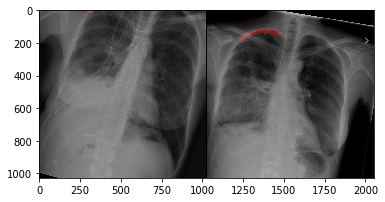

In [0]:
dataiter = iter(train_loader)
sample_images, sample_labels = dataiter.next()

show_images_with_masks(sample_images, sample_labels)

In [0]:
%load_ext tensorboard
%tensorboard --logdir="$NETWORK_OPTIONS_OBJ.TENSORBOARD_LOGS_DIR"
# %reload_ext tensorboard
import time
time.sleep(10)

In [0]:
torch.cuda.empty_cache()

In [0]:
criterion = SIMMSoftDiceLoss()
DiceScore = SIMMHardDiceScore()

In [0]:
import time
timestr = time.strftime("%Y_%m_%d-%H_%M_%S")

run_name = timestr
if NETWORK_OPTIONS_OBJ.CONTINUE_TRAIN == True:
  run_name = NETWORK_OPTIONS_OBJ.RUN_NAME
print(run_name)

tb_log_dir = NETWORK_OPTIONS_OBJ.TENSORBOARD_LOGS_DIR + 'run_' + run_name
tb = SummaryWriter(flush_secs=10, log_dir=tb_log_dir)

# criterion = SIMMSoftDiceLoss()
best_train_loss = 100.0
best_valid_loss = 100.0

if NETWORK_OPTIONS_OBJ.CONTINUE_TRAIN == False:
  tb.add_scalar("learning_rate", NETWORK_OPTIONS_OBJ.LR_RATE)
  tb.add_scalar("batch_size", NETWORK_OPTIONS_OBJ.BATCH_SIZE)
  tb.add_scalar("feature_scale", NETWORK_OPTIONS_OBJ.FEATURE_SCALE)
  # tb.add_image('siim_sample_images', img_grid)
  tb.add_text('run_name', run_name)
  # tb.add_hparams(NETWORK_OPTIONS)
else:
  best_valid_loss = last_best_valid_loss


# tb.add_graph(model, sample_images)

tb.flush()

# Training loop
for epoch in range(NETWORK_OPTIONS_OBJ.START_EPOCH, NETWORK_OPTIONS_OBJ.START_EPOCH + NETWORK_OPTIONS_OBJ.NUM_EPOCHS):
  print('############# Running epoch: %d...\n' % (epoch))

  # Training Iterations

  model.train()

  running_loss = 0.0
  loss_per_epoch = 0.0
  dice_score_per_epoch = 0.0
  epoch_batch_count = 0

  total_iter = total=len(train_loader)
  for epoch_iter, (images, labels) in tqdm(enumerate(train_loader, 1), total=total_iter):
    # Make a training update
    inputs = images.float().to(device)
    masks = labels.to(device)
    # assert input.size() == target.size()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, masks)

    # zero the parameter gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # calculate dice score
    dScore = DiceScore(outputs, masks)

    # update losses for epoch
    loss_per_epoch += loss.item()
    dice_score_per_epoch += dScore.item()
    epoch_batch_count += 1
    # print statistics
    running_loss += loss.item()
    if epoch_iter % 20 == 0:
      #show_images_with_masks_and_prediction(images, labels, outputs)
      loss_avg = running_loss / 20
      #print('[%d, %5d] Running loss: %.3f' % (epoch + 1, epoch_iter + 1, loss_avg))
      # (10 * x + y) / 10
      i_num = (epoch + 1) + ((epoch_iter + 1) / total_iter)
      tb.add_scalar('RunningLoss', loss_avg, i_num)
      running_loss = 0.0

  loss = loss_per_epoch / epoch_batch_count
  dice_score_per_epoch = dice_score_per_epoch / epoch_batch_count
  tb.add_scalar('Loss', loss, epoch + 1)
  tb.add_scalar('DiceScore', dice_score_per_epoch, epoch + 1)
  print('*********** [%d] Loss per epoch: %.3f' %(epoch + 1, loss))
  print('*********** [%d] Dice Score per epoch: %.3f' %(epoch + 1, dice_score_per_epoch))

  if loss <= best_train_loss:
    best_train_loss = loss

  # Validation Iterations

  model.eval()

  running_loss_valid = 0.0
  loss_per_epoch_valid = 0.0
  dice_score_per_epoch_valid = 0.0
  epoch_batch_count_valid = 0
  loss_valid = 100
  if NETWORK_OPTIONS_OBJ.USE_VAL_SET:
    with torch.no_grad():
      total_valid_iter = total=len(valid_loader)
      for epoch_iter, (images, labels) in tqdm(enumerate(valid_loader, 1), total=total_valid_iter):
        # get batch
        inputs = images.float().to(device)
        masks = labels.to(device)
        # assert input.size() == target.size()

        # forward
        outputs = model(inputs)
        loss = criterion(outputs, masks)

        # calculate dice score
        dScore = DiceScore(outputs, masks)

        # update losses for epoch
        loss_per_epoch_valid += loss.item()
        dice_score_per_epoch_valid += dScore.item()
        epoch_batch_count_valid += 1
        running_loss_valid += loss.item()

        if epoch_iter % 20 == 0:
          loss_avg = running_loss_valid / 20
          # print('[%d, %5d] Running loss Validation: %.3f' % (epoch + 1, epoch_iter + 1, loss_avg))
          # (10 * x + y) / 10
          # i_num = (10 * (epoch + 1) + (epoch_iter + 1)) - 10
          i_num = (epoch + 1) + ((epoch_iter + 1) / total_valid_iter)
          tb.add_scalar('RunningLossValidation', loss_avg, i_num)
          running_loss_valid = 0.0

    loss_valid = loss_per_epoch_valid / epoch_batch_count_valid
    dice_score_per_epoch_valid = dice_score_per_epoch_valid / epoch_batch_count_valid
    tb.add_scalar('LossValidation', loss_valid, epoch + 1)
    tb.add_scalar('DiceScoreValidation', dice_score_per_epoch_valid, epoch + 1)
    print('*********** [%d] Validation Loss per epoch: %.3f' %(epoch + 1, loss_valid))
    print('*********** [%d] Validation DiceScore per epoch: %.3f' %(epoch + 1, dice_score_per_epoch_valid))


  is_best = False
  if loss_valid < best_valid_loss:
    best_valid_loss = loss_valid
    is_best = True

  create_checkpoint(run_name, model, optimizer, is_best, epoch, NETWORK_OPTIONS, loss, loss_valid, best_valid_loss)

  # reset loss per epoch
  loss_per_epoch = 0.0
  dice_score_per_epoch = 0.0
  epoch_batch_count = 0
  # reset validation loss per epoch
  loss_per_epoch_valid = 0.0
  dice_score_per_epoch_valid = 0.0
  epoch_batch_count_valid = 0
  
  tb.flush()

  
  # Update the model learning rate
  # model.update_learning_rate()
tb.close()

# Test Set

In [0]:
# Calculate loss on test set
loss_test = 0.0
dScore_test = 0.0
batch_count_test = 0

model.eval()

with torch.no_grad():
  for epoch_iter, (images, labels) in tqdm(enumerate(test_loader, 1), total=len(test_loader)):
    # get batch
    inputs = images.float().to(device)
    masks = labels.to(device)
    # assert input.size() == target.size()

    # forward
    outputs = model(inputs)
    loss = criterion(outputs, masks)
    dScore = DiceScore(outputs.clone(), masks.clone())

    # # update losses for epoch
    loss_test += loss.item()
    dScore_test += dScore.item()
    batch_count_test += 1

    # print('\n -- Loss on Test Set: %.3f' %(loss.item()))
    # print('\n -- Dice score on Test Set: %.3f' %(dScore.item()))

loss_test = loss_test / batch_count_test
dScore_test = dScore_test / batch_count_test
# tb.add_scalar('LossTest', loss_test, loss_test)
print('\n Loss on Test Set: %.3f' %(loss_test))
print('\n Dice score on Test Set: %.3f' %(dScore_test))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))




 Loss on Test Set: 0.501

 Dice score on Test Set: 0.499


# Visualization

In [0]:
def show_heatmap(images):
  # create grid of images
  img_grid = torchvision.utils.make_grid(images.clone().cpu())
  img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))

  plt.figure()
  plt.imshow(img_grid)
  # plt.colorbar()
  plt.show()

In [0]:
# def save_images_with_masks_and_prediction(images, labels, predictions, file_name):
#   # create grid of images
#   img_grid = torchvision.utils.make_grid(images.clone().cpu())
#   target_grid = torchvision.utils.make_grid(labels.clone().cpu())
#   prediction_grid = torchvision.utils.make_grid(predictions.clone().cpu())
#   # print(img_grid.shape)

#   img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))
#   target_grid = np.transpose(target_grid.numpy(), (1, 2, 0))
#   prediction_grid = np.transpose(prediction_grid.numpy(), (1, 2, 0))

#   mask_target = (target_grid == [1.,1.,1.]).all(axis=2)
#   target_grid[mask_target] = [1, 0, 0]

#   mask_pred = (prediction_grid == [1.,1.,1.]).all(axis=2)
#   prediction_grid[mask_pred] = [0, 0, 1]

#   plt.figure()
#   plt.imshow(img_grid, cmap=plt.cm.bone)
#   plt.imshow(target_grid, alpha=0.3)
#   plt.imshow(prediction_grid, alpha=0.3)
#   plt.savefig(file_name)
#   plt.show()

# def save_att_cof(images, file_name):
#   # create grid of images
#   img_grid = torchvision.utils.make_grid(images.clone().cpu())
#   img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))

#   plt.figure()
#   plt.imshow(img_grid)
#   plt.savefig(file_name)
#   plt.show()

In [0]:
# m_name = NETWORK_OPTIONS_OBJ.RUN_NAME
# RESULT_IMG_DIR = IMG_RESULT_SAVE_DIR + m_name
# if os.path.exists(RESULT_IMG_DIR):
#   shutil.rmtree(RESULT_IMG_DIR)
#   print("Deleted RESULT_IMG_DIR directory: " + RESULT_IMG_DIR)

# os.makedirs(RESULT_IMG_DIR)
# print("Created directory: " + RESULT_IMG_DIR)
# %ls '$RESULT_IMG_DIR'

Created directory: /content/gdrive/My Drive/mlmi/results/imgs/2020_01_04-15_27_04


In [0]:
# from IPython.display import clear_output

# model.eval()

# loader = test_loader

# print("Red is Ground Truth.")
# print("Blue is prediction.")

# with torch.no_grad():
#   for epoch_iter, (images, labels) in tqdm(enumerate(loader, 1), total=len(loader)):
#     print("Iter: " + str(epoch_iter))
#     inputs = images.float().to(device)
#     masks = labels.to(device)
#     outputs = model(inputs)
#     att_coffs = model.getLastAttentionCoefficients()

#     outputs[outputs > 0.5] = 1
#     outputs[outputs <= 0.5] = 0
#     fileName = RESULT_IMG_DIR + '/' + str(epoch_iter) + '_test_pred' + '.png'
#     save_images_with_masks_and_prediction(images, labels, outputs, fileName)

#     fileName2 = RESULT_IMG_DIR + '/' + str(epoch_iter) + '_test_att_2' + '.png'
#     save_att_cof(att_coffs[2], fileName2)

#     fileName1 = RESULT_IMG_DIR + '/' + str(epoch_iter) + '_test_att_1' + '.png'
#     save_att_cof(att_coffs[1], fileName1)

#     fileName0 = RESULT_IMG_DIR + '/' + str(epoch_iter) + '_test_att_0' + '.png'
#     save_att_cof(att_coffs[0], fileName0)
#     clear_output(wait=True)
    

In [0]:
model.eval()

# loader = train_loader
# loader = valid_loader
loader = test_loader

max_display = 10
display_count = 0

print("Red is Ground Truth.")
print("Blue is prediction.")

with torch.no_grad():
  for epoch_iter, (images, labels) in tqdm(enumerate(loader, 1), total=len(loader)):
    print("Iter: " + str(epoch_iter))
    # get batch
    inputs = images.float().to(device)
    masks = labels.to(device)

    # forward
    outputs = model(inputs)
    att_coffs = model.getLastAttentionCoefficients()
    # print(att_coff.size())
    # print(outputs.size())

    outputs[outputs > 0.5] = 1
    outputs[outputs <= 0.5] = 0

    show_images_with_masks_and_prediction(images, labels, outputs)

    show_heatmap(att_coffs[2])
    show_heatmap(att_coffs[1])
    show_heatmap(att_coffs[0])

    display_count += 1
    if display_count >= max_display:
      break